In [2]:
!pip install zuko
import torch
import zuko
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the dimensions
sample_features = 2  # Number of sample features (x), reduced for 2D plotting
context_features = 1  # Number of context features (c)

# Define a non-Gaussian target distribution (Mixture of Gaussians)
# Mixture parameters
num_mixtures = 3
weights = np.array([0.4, 0.3, 0.3])
means = np.array([[2.0, -1.0], [-1.0, 1.0], [1.0, 3.0]])
covariances = np.array([[[1.0, 0.5], [0.5, 1.0]],
                        [[0.7, 0.3], [0.3, 0.7]],
                        [[1.5, -0.5], [-0.5, 1.5]]])

# Function to sample from the mixture distribution
def sample_from_mixture(num_samples, weights, means, covariances):
    components = np.random.choice(len(weights), size=num_samples, p=weights)
    samples = np.zeros((num_samples, 2))
    for i in range(num_samples):
        samples[i] = np.random.multivariate_normal(means[components[i]], covariances[components[i]])
    return samples

# Generate synthetic dataset based on the mixture distribution
def generate_synthetic_dataset(num_samples, weights, means, covariances):
    samples = sample_from_mixture(num_samples, weights, means, covariances)
    x = samples.astype(np.float32)
    c = np.random.randn(num_samples, context_features).astype(np.float32)
    dataset = [(torch.tensor(x[i]), torch.tensor(c[i])) for i in range(num_samples)]
    return dataset

num_samples = 100  # Number of samples in the dataset
trainset = generate_synthetic_dataset(num_samples, weights, means, covariances)

# Define the NSF model
flow = zuko.flows.GF(sample_features, context_features, transforms=3, hidden_features=[128] * 3)

# Train to maximize the log-likelihood
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# Lists to store training statistics
train_losses = []
valid_losses = []

# Training loop
for epoch in range(100):
    # Training phase
    flow.train()
    epoch_train_loss = 0.0
    for x, c in trainset:
        x = x.unsqueeze(0)  # Add batch dimension
        c = c.unsqueeze(0)  # Add batch dimension

        loss = -flow(c).log_prob(x)  # -log p(x | c)
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(trainset)
    train_losses.append(epoch_train_loss)

    # Validation phase (for illustration purpose only, not using validation set here)
    flow.eval()
    epoch_valid_loss = epoch_train_loss  # Assume no separate validation set

    valid_losses.append(epoch_valid_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/100], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")

# Generate samples from the learned distribution
# Generate a random context c*
c_star = torch.randn(1, context_features)


Epoch [10/100], Train Loss: 3.8945, Valid Loss: 3.8945
Epoch [20/100], Train Loss: 3.8839, Valid Loss: 3.8839
Epoch [30/100], Train Loss: 3.6125, Valid Loss: 3.6125
Epoch [40/100], Train Loss: 3.6163, Valid Loss: 3.6163
Epoch [50/100], Train Loss: 3.4916, Valid Loss: 3.4916
Epoch [60/100], Train Loss: 3.3018, Valid Loss: 3.3018
Epoch [70/100], Train Loss: 3.2810, Valid Loss: 3.2810
Epoch [80/100], Train Loss: 3.1942, Valid Loss: 3.1942
Epoch [90/100], Train Loss: 3.1351, Valid Loss: 3.1351
Epoch [100/100], Train Loss: 3.0620, Valid Loss: 3.0620


<ipython-input-8-4b50b4602877>:31: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')


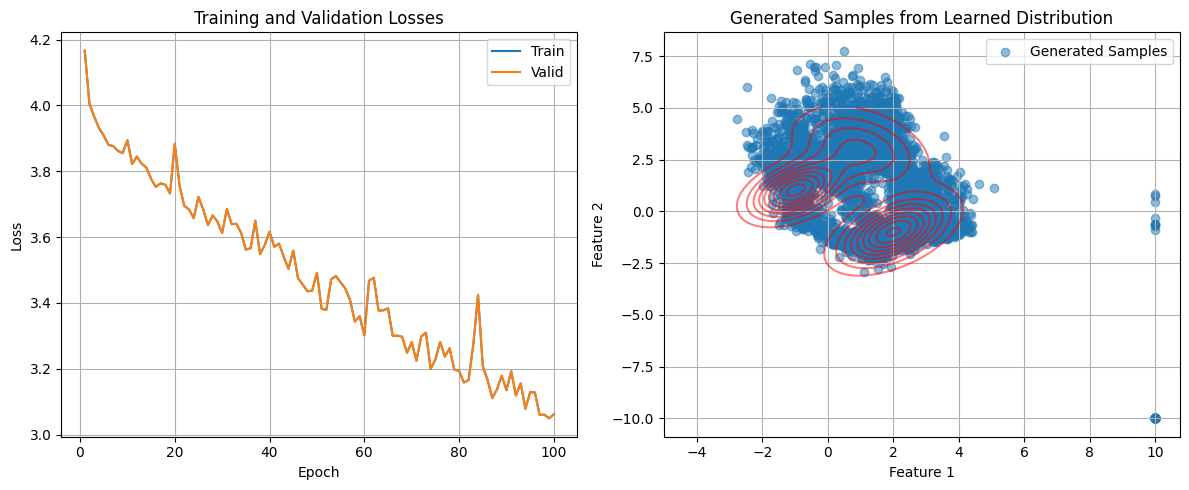

In [8]:
x_samples = flow(c_star).sample((6400,)).detach().numpy()

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot generated samples from the learned distribution
plt.subplot(1, 2, 2)
plt.scatter(x_samples[:, 0, 0], x_samples[:,0, 1], label='Generated Samples', alpha=0.5)
plt.title('Generated Samples from Learned Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
pos = np.dstack((x1, x2))
target_pdf = np.zeros_like(x1)
for i in range(num_mixtures):
    mv = multivariate_normal(means[i], covariances[i])
    target_pdf += weights[i] * mv.pdf(pos)
plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')

plt.tight_layout()
plt.show()

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the dimensions
sample_features = 2  # Number of sample features (x), reduced for 2D plotting
context_features = 1  # Number of context features (c)

# Define a non-Gaussian target distribution (Mixture of Gaussians)
# Mixture parameters
num_mixtures = 3
weights = np.array([0.4, 0.3, 0.3])
means = np.array([[2.0, -1.0], [-1.0, 1.0], [1.0, 3.0]])
covariances = np.array([[[1.0, 0.5], [0.5, 1.0]],
                        [[0.7, 0.3], [0.3, 0.7]],
                        [[1.5, -0.5], [-0.5, 1.5]]])

# Function to sample from the mixture distribution
def sample_from_mixture(num_samples, weights, means, covariances):
    components = np.random.choice(len(weights), size=num_samples, p=weights)
    samples = np.zeros((num_samples, 2))
    for i in range(num_samples):
        samples[i] = np.random.multivariate_normal(means[components[i]], covariances[components[i]])
    return samples

# Generate synthetic dataset based on the mixture distribution
def generate_synthetic_dataset(num_samples, weights, means, covariances):
    samples = sample_from_mixture(num_samples, weights, means, covariances)
    x = samples.astype(np.float32)
    c = np.random.randn(num_samples, context_features).astype(np.float32)
    dataset = [(torch.tensor(x[i]), torch.tensor(c[i])) for i in range(num_samples)]
    return dataset

# Split dataset into training and validation sets
num_samples = 1000  # Number of samples in the dataset
split_ratio = 0.8  # 80% training, 20% validation
num_train_samples = int(num_samples * split_ratio)
num_valid_samples = num_samples - num_train_samples

dataset = generate_synthetic_dataset(num_samples, weights, means, covariances)
trainset = dataset[:num_train_samples]
validset = dataset[num_train_samples:]

# Define the NSF model
flow = zuko.flows.GF(sample_features, context_features, transforms=3, hidden_features=[128] * 3)

# Train to maximize the log-likelihood
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# Lists to store training and validation losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(25):
    # Training phase
    flow.train()
    epoch_train_loss = 0.0
    for x, c in trainset:
        x = x.unsqueeze(0)  # Add batch dimension
        c = c.unsqueeze(0)  # Add batch dimension

        loss = -flow(c).log_prob(x)  # -log p(x | c)
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(trainset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    flow.eval()
    epoch_valid_loss = 0.0
    with torch.no_grad():
        for x, c in validset:
            x = x.unsqueeze(0)  # Add batch dimension
            c = c.unsqueeze(0)  # Add batch dimension

            loss = -flow(c).log_prob(x)  # -log p(x | c)
            loss = loss.mean()

            epoch_valid_loss += loss.item()

    epoch_valid_loss /= len(validset)
    valid_losses.append(epoch_valid_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/25], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")

# Generate samples from the learned distribution
# Generate a random context c*
c_star = torch.randn(1, context_features)



Epoch [10/100], Train Loss: 3.7496, Valid Loss: 3.7118
Epoch [20/100], Train Loss: 3.7251, Valid Loss: 3.7140


<ipython-input-15-18c8fed091cf>:32: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')


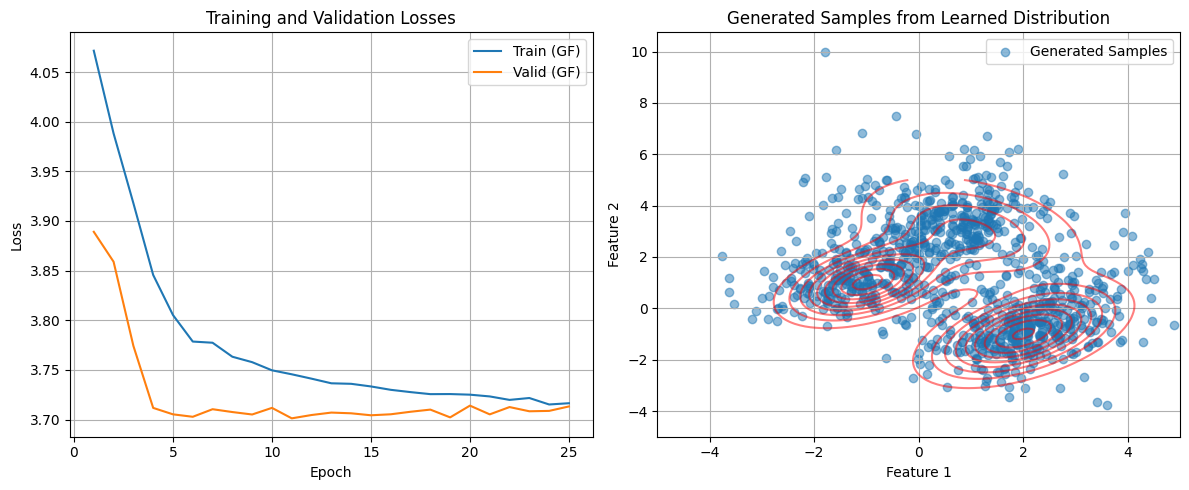

In [15]:
# Sample 64 points x ~ p(x | c*)
x_samples = flow(c_star).sample((1000,)).detach().numpy()  # Convert to numpy array for plotting

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train (GF)')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid (GF)')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot generated samples from the learned distribution
plt.subplot(1, 2, 2)
plt.scatter(x_samples[:, 0, 0], x_samples[:, 0, 1], label='Generated Samples', alpha=0.5)
plt.title('Generated Samples from Learned Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
pos = np.dstack((x1, x2))
target_pdf = np.zeros_like(x1)
for i in range(num_mixtures):
    mv = multivariate_normal(means[i], covariances[i])
    target_pdf += weights[i] * mv.pdf(pos)
plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')

plt.tight_layout()
plt.show()

In [17]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the dimensions
sample_features = 2  # Number of sample features (x), reduced for 2D plotting
context_features = 1  # Number of context features (c)

# Define a non-Gaussian target distribution (Mixture of Gaussians)
# Mixture parameters
num_mixtures = 3
weights = np.array([0.4, 0.3, 0.3])
means = np.array([[2.0, -1.0], [-1.0, 1.0], [1.0, 3.0]])
covariances = np.array([[[1.0, 0.5], [0.5, 1.0]],
                        [[0.7, 0.3], [0.3, 0.7]],
                        [[1.5, -0.5], [-0.5, 1.5]]])

# Function to sample from the mixture distribution
def sample_from_mixture(num_samples, weights, means, covariances):
    components = np.random.choice(len(weights), size=num_samples, p=weights)
    samples = np.zeros((num_samples, 2))
    for i in range(num_samples):
        samples[i] = np.random.multivariate_normal(means[components[i]], covariances[components[i]])
    return samples

# Generate synthetic dataset based on the mixture distribution
def generate_synthetic_dataset(num_samples, weights, means, covariances):
    samples = sample_from_mixture(num_samples, weights, means, covariances)
    x = samples.astype(np.float32)
    c = np.random.randn(num_samples, context_features).astype(np.float32)
    dataset = [(torch.tensor(x[i]), torch.tensor(c[i])) for i in range(num_samples)]
    return dataset

# Split dataset into training and validation sets
num_samples = 1000  # Number of samples in the dataset
split_ratio = 0.8  # 80% training, 20% validation
num_train_samples = int(num_samples * split_ratio)
num_valid_samples = num_samples - num_train_samples

dataset = generate_synthetic_dataset(num_samples, weights, means, covariances)
trainset = dataset[:num_train_samples]
validset = dataset[num_train_samples:]

# Define the NSF model
flow = zuko.flows.NSF(sample_features, context_features, transforms=3, hidden_features=[128] * 3)

# Train to maximize the log-likelihood
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# Lists to store training and validation losses
train_losses_nsf = []
valid_losses_nsf = []

# Training loop
for epoch in range(25):
    # Training phase
    flow.train()
    epoch_train_loss = 0.0
    for x, c in trainset:
        x = x.unsqueeze(0)  # Add batch dimension
        c = c.unsqueeze(0)  # Add batch dimension

        loss = -flow(c).log_prob(x)  # -log p(x | c)
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(trainset)
    train_losses_nsf.append(epoch_train_loss)

    # Validation phase
    flow.eval()
    epoch_valid_loss = 0.0
    with torch.no_grad():
        for x, c in validset:
            x = x.unsqueeze(0)  # Add batch dimension
            c = c.unsqueeze(0)  # Add batch dimension

            loss = -flow(c).log_prob(x)  # -log p(x | c)
            loss = loss.mean()

            epoch_valid_loss += loss.item()

    epoch_valid_loss /= len(validset)
    valid_losses_nsf.append(epoch_valid_loss)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/25], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")

# Generate samples from the learned distribution
# Generate a random context c*
c_star = torch.randn(1, context_features)



Epoch [5/25], Train Loss: 3.8991, Valid Loss: 3.9555
Epoch [10/25], Train Loss: 3.8587, Valid Loss: 3.9739
Epoch [15/25], Train Loss: 3.8105, Valid Loss: 4.0003
Epoch [20/25], Train Loss: 3.7599, Valid Loss: 3.9472
Epoch [25/25], Train Loss: 3.7894, Valid Loss: 3.9491


<ipython-input-23-aeeea8222b1e>:34: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')


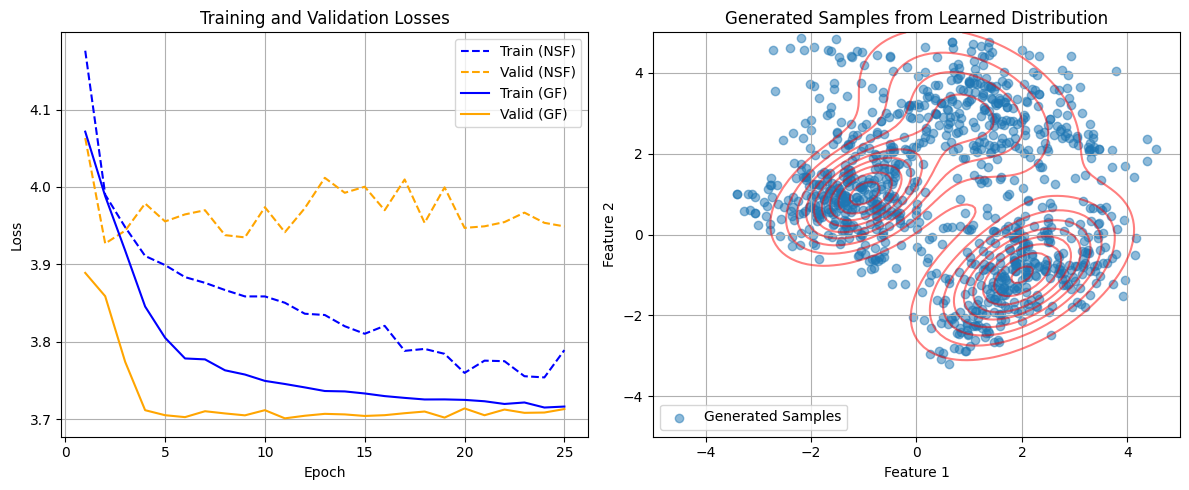

In [23]:
# Sample 64 points x ~ p(x | c*)
x_samples_nsf = flow(c_star).sample((1000,)).detach().numpy()  # Convert to numpy array for plotting

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_nsf) + 1), train_losses_nsf, label='Train (NSF)', color = 'blue', linestyle='dashed')
plt.plot(range(1, len(valid_losses_nsf) + 1), valid_losses_nsf, label='Valid (NSF)', color = 'orange', linestyle='dashed')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train (GF)', color = 'blue')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid (GF)', color = 'orange')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot generated samples from the learned distribution
plt.subplot(1, 2, 2)
plt.scatter(x_samples_nsf[:, 0, 0], x_samples_nsf[:, 0, 1], label='Generated Samples', alpha=0.5)
plt.title('Generated Samples from Learned Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
pos = np.dstack((x1, x2))
target_pdf = np.zeros_like(x1)
for i in range(num_mixtures):
    mv = multivariate_normal(means[i], covariances[i])
    target_pdf += weights[i] * mv.pdf(pos)
plt.contour(x1, x2, target_pdf, levels=9, colors='r', alpha=0.5, label='Target Distribution')

plt.tight_layout()
plt.show()